In [1]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
data[1]

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.'}

## **CONVERTING INSTRUCTIONS INTO ALPACA FORMAT**

### What is Alpaca ?

Stanford Alpaca is a language model developed by researchers at Stanford University in March 2023.

It’s based on Meta’s LLaMA (Large Language Model Meta AI) models, which are large foundational language models

Stanford researchers wanted to create a smaller, more accessible version of large language models, which is fine-tuned to follow instructions well (similar to ChatGPT).

Their main goals were:

- To show that instruction-following models can be made cheaply.

- To make it easier for researchers and developers to experiment with these models.

⚙️ How did they make Alpaca?
- 1️⃣ They started with LLaMA 7B, a 7-billion-parameter model from Meta.
- 2️⃣ They fine-tuned it using instruction-following data, which they generated by prompting OpenAI's text-davinci-003 model to produce 52,000 instruction-response pairs.
- 3️⃣ The fine-tuning cost was only about $500, which showed it’s possible to make a strong instruction model without huge budgets.


In [3]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [4]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [5]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


## **Splitting Dataset into Train, val and Test split**

In [6]:
train_portion = int(len(data) * 0.85) # 85% for training
test_portion = int(len(data) * 0.10) # 10% for testing
val_portion = len(data) - train_portion - test_portion # 5% for val

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [7]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## STEP 2: ORGANIZING DATA INTO TRAINING BATCHES

A collate function is responsible for taking a list of individual data samples and merging them into a single batch that can be processed efficiently by the model during training.

In [8]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data 

        # Pre-tokenize text 
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response: \n{entry['output']}"
            full_text = instruction_plus_input + response_text 
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
        
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    
    def __len__(self):
        return len(self.data)

Instead of appending the <|endoftext|> tokens to the text inputs, we can append its token ID to the pre-tokenized inputs directly.

To remind us which token ID we should use, we can use the tokenizer's .encode method on an <|endoftext|> token:

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


we padded all examples in a dataset to the same length.

Moving on, here, we adopt a more sophisticated approach by developing a custom collate function that we can pass to the data loader.

This custom collate function pads the training examples in each batch to have the same length, while allowing different batches to have different lengths.

This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset.

We can implement the padding process with a custom collate function as follows:

- Step 1: Find the longest sequence in the batch

- Step 2: Pad and prepare inputs

- Step 3: Remove extra padded token added earlier

- Step 4: Convert list of inputs to tensor and transfer to target device

In [10]:
def custom_collate_draft_1(
        batch, 
        pad_token_id = 50256, 
        device = None
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare the inputs 
    input_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token that has been added via the +1 setting in batch_max_length (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        input_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(input_lst).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1, 
    inputs_2, 
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


all inputs have been padded to the length of the longest input list, inputs_1 containing 5 token IDs.

We also need to create batches with the target token IDs, corresponding to the batch of input IDs.

These target IDs are crucial because they represent what we want the model to generate and what we need during training to calculate the loss for the weight updates, similar to previous chapters.

## CREATING TARGET TOKEN IDS FOR TRAINING

Similar to the process described for pretraining an LLM, the target token IDs match the input token IDs but are shifted one position to the right.

This setup allows the LLM to learn how to predict the next token in a sequence

In [12]:
def custom_collate_draft_2(
        batch, 
        padded_token_id = 50256, 
        device = None
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs 
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [padded_token_id]
        # Pad Sequences to max length 
        padded = (
            new_item + [padded_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs 
        targets = torch.tensor(padded[1:]) # Shift + 1 to the right of targets 
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

Step 1: Truncate the last token for inputs
                               
Step 2: Shift +1 to the right for targets

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


The 1st tensor represents inputs.
    
The 2nd tensor represents the targets

In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contributing to
the training loss calculation, ensuring that only meaningful data influences model learning.

In classification fine-tuning, we did not have to worry about this since we only trained the model based on
the last output token.

In the following code, we modify our custom collate function to replace tokens with ID
50256 with -100 in the target lists.

Additionally, we introduce
an allowed_max_length parameter to optionally limit the length of the samples. 

This
adjustment will be useful if you plan to work with your own datasets that exceed the 1024-
token context size supported by the GPT-2 model. 

In [14]:
def custom_collate(batch, pad_token_id = 50256, allowed_max_length = None, device = None, ignore_index = -100):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare the input and targets 
    input_lst, target_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max length 
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # Truncate the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # Shift +1 to the right for targets
        targets = torch.tensor(padded[1:])

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id 
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        input_lst.append(inputs)
        target_lst.append(targets)
    
    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(input_lst).to(device)
    targets_tensor = torch.stack(target_lst).to(device)

    return inputs_tensor, targets_tensor

In [15]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate(batch)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [17]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


what happens if we replace the third target token ID with -100:

In [18]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


So, what's so special about -100 that it's ignored by the cross entropy loss? The default setting of the cross entropy function in PyTorch is cross_entropy(..., ignore_index=-100).

This means that it ignores targets labeled with -100.

## **Step 3: Create DataLoaders for Instruction dataset**

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [20]:
from functools import partial 
customized_collate_fn = partial(custom_collate, device = device, allowed_max_length = 1024)

In [21]:
from torch.utils.data import DataLoader 

num_workers = 0 
batch_size = 8 
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          collate_fn=customized_collate_fn, 
                          shuffle=True, 
                          drop_last=True, 
                          num_workers=num_workers)

val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size,
                        collate_fn=customized_collate_fn, 
                        shuffle=False, 
                        drop_last=False, 
                        num_workers=num_workers)

test_loader = DataLoader(test_dataset, 
                         batch_size = batch_size,
                         collate_fn=customized_collate_fn, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers)

In [22]:
# print("Train loader:")
# for inputs, targets in train_loader:
#     print(inputs.shape, targets.shape)

In [23]:
import sys
import os
import json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from GPT.GPT_Model import GPTModel
from GPT.Model_Weights_Loading import load_weights_into_gpt
from GPT.gpt_download import download_and_load_gpt2
from GPT.Text_Generation import generate, generate_and_print_sample
from GPT.Text_Generation import text_to_tokens, token_to_text

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [24]:
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="C:\\Users\\hites\\OneDrive\\Desktop\\GPT\\gpt2_355M"
)

c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\checkpoint


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\encoder.json


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\hparams.json


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\model.ckpt.data-00000-of-00001


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\model.ckpt.index


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\model.ckpt.meta


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\vocab.bpe


In [25]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [26]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [27]:
val_data[0]

{'instruction': "Convert the active sentence to passive: 'The chef cooks the meal every day.'",
 'input': '',
 'output': 'The meal is cooked by the chef every day.'}

In [28]:
token_ids = generate(
    model=model,
    idx=text_to_tokens(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_to_text(token_ids, tokenizer)

In [29]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

ropolisFD tracing ##### salad sprang(& seminars Piercing Spartan Electrical deserted Drops Huff Davational786011 restitution gazed beardedHistory noveltyalyst483 Integvind champagne 106 Panama mortgage Third hurricaneselve Comed


## **Finetuning LLM on Instruction data**

In [30]:
import tqdm

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()  
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, start_context, device)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

#### **Loss without optimization**

In [31]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.050865364074706
Validation loss: 11.035743522644044


### **Training LLM**

In [32]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 4

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

  0%|          | 0/4 [00:00<?, ?it/s]

Ep 1 (Step 000000): Train loss 8.384, Val loss 8.512
Ep 1 (Step 000005): Train loss 4.736, Val loss 4.745
Ep 1 (Step 000010): Train loss 4.048, Val loss 4.171
Ep 1 (Step 000015): Train loss 3.725, Val loss 3.877
Ep 1 (Step 000020): Train loss 3.516, Val loss 3.704
Ep 1 (Step 000025): Train loss 3.466, Val loss 3.552
Ep 1 (Step 000030): Train loss 3.214, Val loss 3.434
Ep 1 (Step 000035): Train loss 3.199, Val loss 3.336
Ep 1 (Step 000040): Train loss 3.025, Val loss 3.258
Ep 1 (Step 000045): Train loss 2.880, Val loss 3.158
Ep 1 (Step 000050): Train loss 3.176, Val loss 3.082
Ep 1 (Step 000055): Train loss 3.040, Val loss 3.018
Ep 1 (Step 000060): Train loss 2.868, Val loss 2.943
Ep 1 (Step 000065): Train loss 2.745, Val loss 2.872
Ep 1 (Step 000070): Train loss 2.413, Val loss 2.825
Ep 1 (Step 000075): Train loss 2.431, Val loss 2.768
Ep 1 (Step 000080): Train loss 2.566, Val loss 2.719
Ep 1 (Step 000085): Train loss 2.482, Val loss 2.689
Ep 1 (Step 000090): Train loss 2.592, Val loss

 25%|██▌       | 1/4 [41:28<2:04:24, 2488.30s/it]

Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'   ### Response:  The a is 'I.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.
Ep 2 (Step 000120): Train loss 2.096, Val loss 2.496
Ep 2 (Step 000125): Train loss 2.066, Val loss 2.485
Ep 2 (Step 000130): Train loss 1.947, Val loss 2.450
Ep 2 (Step 000135): Train loss 2.154, Val loss 2.435
Ep 2 (Step 000140): Train loss 2.144, Val loss 2.398
Ep 2 (Step 000145): Train loss 1.953, Val loss 2.383
Ep 2 (Step 000150): Train loss 1.964, Val loss 2.355
Ep 2 (Step 000155): Train loss 2.076, Val loss 2.353
Ep 2 (Step 000160): Train loss 1.985, Val loss 2.359
Ep 2 (Step 000165): Train loss 2.028, Val

 50%|█████     | 2/4 [1:16:37<1:15:30, 2265.16s/it]

Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response:  The chemical symbol for 'I love.<|endoftext|>.<|endoftext|>.<|endoftext|>'.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|> the sentence.<|endoftext|>.<|endoftext|>.<|endoftext|> the sentence.<|endoftext|>.<|endoftext|>.<|endoftext|> the sentence
Ep 3 (Step 000235): Train loss 1.670, Val loss 2.158
Ep 3 (Step 000240): Train loss 1.422, Val loss 2.149
Ep 3 (Step 000245): Train loss 1.500, Val loss 2.144
Ep 3 (Step 000250): Train loss 1.679, Val loss 2.123
Ep 3 (Step 000255): Train loss 1.631, Val loss 2.129
Ep 3 (Step 000260): Train loss 1.560, Val loss 2.113
Ep 3 (Step 000265): Train loss 1.629, Val loss 2.096
Ep 3 (Step 000270): Train loss 1.694, Val loss 2.099
Ep 3 (Step 000275): Train loss 1.589, Val loss 2.105
Ep 3 (Step 000280): Train

 75%|███████▌  | 3/4 [1:48:42<35:09, 2109.86s/it]  

Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response:  The past tense of the following sentence to the sentence is 'I love a' is 'I love this sentence.<|endoftext|>'.<|endoftext|>'.<|endoftext|>.<|endoftext|>.<|endoftext|>.'<|endoftext|> the and 'I.<|endoftext|>'.<|endoftext|>.
Ep 4 (Step 000350): Train loss 1.487, Val loss 2.020
Ep 4 (Step 000355): Train loss 1.300, Val loss 2.013
Ep 4 (Step 000360): Train loss 1.230, Val loss 2.013
Ep 4 (Step 000365): Train loss 1.251, Val loss 2.018
Ep 4 (Step 000370): Train loss 1.398, Val loss 1.985
Ep 4 (Step 000375): Train loss 1.267, Val loss 2.005
Ep 4 (Step 000380): Train loss 1.279, Val loss 1.984
Ep 4 (Step 000385): Train loss 1.220, Val loss 1.982
Ep 4 (Step 000390): Train loss 1.133, Val loss 1.973
Ep 4 (Step 000395): Train loss 1.109, Val loss 1.978
Ep 4 (Step 000400): Train loss

100%|██████████| 4/4 [2:20:48<00:00, 2112.09s/it]

Below is an instruction that describes a task.Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response:  The past participle form of the game.<|endoftext|>.<|endoftext|>.<|endoftext|>.'<|endoftext|>.<|endoftext|>.<|endoftext|>.<|endoftext|> the word 'The past participle form of 'The past participle form of the past participle form
Training completed in 141.08 minutes.


### **Loss Curves**

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

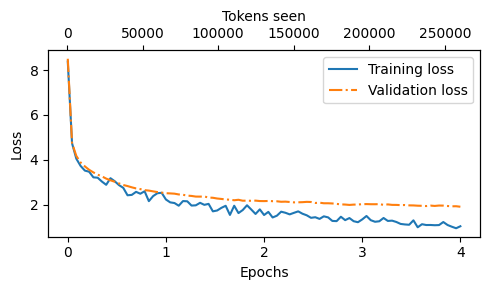

In [34]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [35]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_tokens(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The process by the sentence is the sentence is the world is the sentence.
-------------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The formula for the United States is to go for the area of the body.
-------------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model re

In [36]:
from tqdm import tqdm 

for i, entry in tqdm(enumerate(test_data), total = len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(model, idx = text_to_tokens(input_text, tokenizer), max_new_tokens=256, context_size=BASE_CONFIG["context_length"], eos_id=50256)
    generated_text = generated_text[len(input_text):].replace("### Response: ", "").strip()

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent = 4)

100%|██████████| 110/110 [36:50<00:00, 20.10s/it]


In [37]:
file_name = "GPT355M.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as GPT355M.pth
